In [1]:
import pandas as pd
import os
from datetime import date, timedelta
import datetime
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.statespace.sarimax import SARIMAX
# grid search sarima hyperparameters for monthly mean temp dataset
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
ROOT_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))
pkl_loc = os.path.join(ROOT_DIR, 'data', 'data','weatherAA.pkl')
pkl_loc

'C:\\Users\\paull\\OneDrive - Scandinavian Tobacco Group A S\\Documents\\GitHub\\Weatherman\\data\\data\\weatherAA.pkl'

### Reading In Data and trimming

In [2]:
df = pd.read_pickle(pkl_loc)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146330 entries, 2006-01-01 00:00:00 to 2022-10-07 00:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   temp    145799 non-null  float64
 1   dwpt    145582 non-null  float64
 2   rhum    145582 non-null  float64
 3   prcp    133375 non-null  float64
 4   snow    0 non-null       float64
 5   wdir    122688 non-null  float64
 6   wspd    145397 non-null  float64
 7   wpgt    0 non-null       float64
 8   pres    141933 non-null  float64
 9   tsun    0 non-null       float64
 10  coco    6519 non-null    float64
dtypes: float64(11)
memory usage: 13.4 MB


In [3]:
df.drop(columns=['snow', 'wpgt','tsun','coco'],inplace=True)
df.reset_index(inplace=True)
df=df[df['time']<'2022-09-22 23:00:00'] #matching end of existing data


### Finding Gaps in the Time data

In [4]:
dftime=df.copy(deep=True)

In [5]:
dftime['timediff']=dftime['time'].diff(periods=1) #difference for hours
dftime['timediff']=dftime['timediff']/pd.Timedelta(hours=1) #converted to hour int
dftime[dftime['timediff']>4]

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,timediff
2355,2006-04-10 17:00:00,13.9,1.2,42.0,0.0,180.0,13.0,NaN,38.0
6893,2006-10-18 06:00:00,11.1,9.4,89.0,NaN,220.0,11.2,NaN,27.0
11274,2007-04-19 04:00:00,6.1,2.7,79.0,0.0,30.0,11.2,1015.1,7.0
28501,2009-04-07 00:00:00,3.3,-6.1,50.0,0.0,330.0,22.3,1003.8,9.0
38008,2010-05-09 20:00:00,12.2,-3.2,34.0,0.0,280.0,20.5,NaN,29.0
38663,2010-06-06 20:00:00,19.4,12.2,63.0,0.0,280.0,13.0,1007.0,18.0
39795,2010-07-24 21:00:00,29.4,20.6,59.0,0.0,300.0,20.5,1010.6,22.0
56859,2012-07-06 18:00:00,36.1,21.2,42.0,NaN,NaN,0.0,1013.7,33.0
56866,2012-07-07 12:00:00,30.0,22.2,63.0,0.0,260.0,11.2,1012.0,12.0
61586,2013-01-20 20:00:00,-5.6,-14.9,48.0,0.0,300.0,25.9,NaN,14.0


In [6]:
#ended up not needing

def buildtime(df,diff): #function takes in a DF(with timediff column) and how far back you want to adjust, creates rows for all missing values
    df=df[(df['timediff']<=diff) & (dftime['timediff']>1)]
    l=[]
    for ind in df.index:
        gap=int(df.loc[ind]['timediff'])
        for d in range(1,gap):
            l.append(df.loc[ind]['time']-timedelta(hours=d))
    return pd.DataFrame(l,columns=['time'])


In [7]:
def allmissing(df): #Creates NANS rows for all missing values
    timemax=df.time.max()
    timemin=df.time.min()
    time_range = pd.date_range(timemin, timemax, freq='H')
    df_time=pd.DataFrame(time_range, columns=['time'])
    result=df_time.merge(df,left_on=['time'], right_on=['time'], how='left') #new df with nulls 
    return result


In [8]:
df=allmissing(df)

In [9]:
def calcnums(df, col): #Counts the max # of Nan values and adds as a column
    df['NaNcount']=df[col].isnull().astype(int).groupby(df[col].notnull().astype(int).cumsum()).cumsum() #counting the number missing reseting at 0
    df['NaNmax']=df[::-1].groupby(df['NaNcount'].eq(0).cumsum())['NaNcount'].cummax()
    return df

df=calcnums(df,'temp')

In [10]:
df.set_index('time', inplace=True)
df.loc['2018-01-14 00:00:00':'2018-01-15 23:00:00']

,temp,dwpt,rhum,prcp,wdir,wspd,pres,NaNcount,NaNmax
time,,,,,,,,,
2018-01-14 00:00:00,-10.0,-15.5,64.0,0.0,280.0,7.6,1035.6,0,0
2018-01-14 01:00:00,-10.0,-15.5,64.0,0.0,270.0,7.6,1036.3,0,0
2018-01-14 02:00:00,-10.6,-15.5,67.0,0.0,240.0,5.4,1036.5,0,0
2018-01-14 03:00:00,-13.9,-16.2,83.0,0.0,NaN,0.0,1036.8,0,0
2018-01-14 04:00:00,-15.0,-16.1,91.0,0.0,NaN,0.0,1037.2,0,0
2018-01-14 05:00:00,-16.7,-17.8,91.0,0.0,NaN,0.0,1037.5,0,0
2018-01-14 06:00:00,-16.7,-18.9,83.0,0.0,NaN,0.0,1037.6,0,0
2018-01-14 07:00:00,-13.3,-15.0,87.0,0.0,NaN,0.0,1037.7,0,0
2018-01-14 08:00:00,-11.7,-14.5,80.0,0.0,220.0,5.4,1037.9,0,0


In [11]:
def sarima_forecast(history, config,delta):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    #yhat=history.iloc[-1:].index[0]
    start_predict=history.iloc[-1:].index[0]+timedelta(hours=1)
    end_predict=start_predict+timedelta(hours=delta-1)
    yhat = model_fit.predict(start_predict, end_predict)
    return yhat
 
def loopsarima(df, col): #function takes in a DF(with timediff column) and how far back you want to adjust, creates rows for all missing values and adds them in
    for ind in df.index:
        #print(df.loc[ind]['NaNmax'])
        if df.loc[ind]['NaNmax']==0:
            None
        else:
            hs=df.loc[ind].name-timedelta(days=30) #building the SARIMAX back 30 days for every missing value
            minind=df.index.min()
            if minind>hs: #checks to see if value is in the first 30 days, uses first value if so
                hs=minind
            df_hs=df.loc[hs:ind]
            config=[(1,0,0),(0,1,0,24),'n'] #found from the first SARIMAX all possible scans
            #config=[(2, 0, 2), (0, 1, 0, 24), 't']
            try:
            # never show warnings when grid searching, too noisy
                with catch_warnings():
                    filterwarnings("ignore")
                    yhat=sarima_forecast(df_hs[col],config,int(df.loc[ind]['NaNmax']))
            except:
                error = None
            yhat.rename('temp',inplace=True)
            yhat = pd.DataFrame(yhat)
            df.at[ind,'NaNmax']=0 #changing all values to 0 so SARIMA function isn't called for each value
            yhat['NaNmax']=0
            df.update(yhat)
    return df

df2=loopsarima(df, 'temp')

#df[(df['time']>'2020-12-10 15:00:00')&(df['time']<='2020-12-11 23:00:00')].head(60)

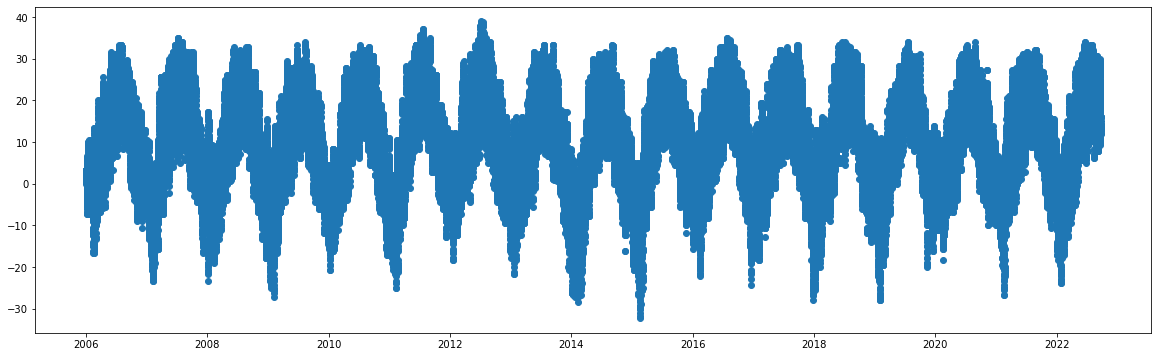

-32.2

In [15]:
x= df2.index
y= df2['temp']

figure(figsize=(20,6))
plt.scatter(x,y)
plt.show()

df2.temp.min()

In [16]:
cln_pkl_loc = os.path.join(ROOT_DIR, 'data','AAcleaned.pkl')
df2.to_pickle(cln_pkl_loc)


In [13]:
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	#print('starting walk_forward_validation')
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)  
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	#print(error)
	#print('ending grid_search')
	return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	#print('starting score_model')
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	#if result is not None:
		#print(' > Model[%s] %.3f' % (key, result))
	#print('ending grid_search')
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=False):
	#print('starting grid_search')
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count())#, backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	#print('ending grid_search')
	return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	#print('starting sarima_configs')
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	#print('ending sarima_configs')
	return models

done


NameError: name 'scores' is not defined

In [ ]:
df2.loc['2020-09-01 00:00:00':]['temp']